In [14]:
%matplotlib inline
from ipywidgets import interactive
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

In [ ]:
# Uncoment the next line if you are using Google Colab
#!pip install git+https://github.com/Guillaume-Garrigos/invprob.git
import invprob.sparse as sparse

In [15]:
np.random.seed(seed=78) # Seed for np.random
dpi = 100 # Resolution used for plotting (230 for small screen, 100 for large one)
folder = "output/L1_reg/"

# Notes on Inverse Problems by Guillaume Garrigos
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\EE}{\mathbb{E}}$

## I. Sparse Regularisation with the L1 norm (LASSO) : the regularization path

We try here to recover a ground truth signal $x_0\in \RR^N$, being given a finite number of linear measurments:

\begin{equation}
y = \Phi x
\end{equation}

where $\Phi \in \RR^{M\times N}$ and $y \in \RR^M$.

To do so, we are going to exploit a prior assumption on $x_0$, which is that it is a *sparse* vector, in the sense that it has numerous zero entries.
More precisely, we assume that $x_0$ is the solution of the following optimisation problem

\begin{equation}\label{Eq:true problem}
\min\limits_{y = \Phi x} \ \Vert x \Vert_1 , \hspace{1cm} \text{ where } \Vert x \Vert_1 := \sum_{i=1}^N \vert x_i \vert.
\tag{$P_0$}
\end{equation}

### 1. Presentation of the problem

We define $\Phi$, $x_0$ and $y$.

In [16]:
# We start by defining the characteristics of the problem: dimensions, sparsity level, etc.
data_size = 100 
data_number = round(data_size/2)
sparsity_level = 10

# We define the main components of our problem
Phi = np.random.randn(data_number,data_size)
x0 = np.sign(sparse.randn(data_size,1,sparsity_level))
y = Phi@x0

Let's compare the ground truth $x_0$ with the pseudo inverse solution of the linear system $\Phi x = y$, that is, $x^\dagger := \Phi^\dagger y$.

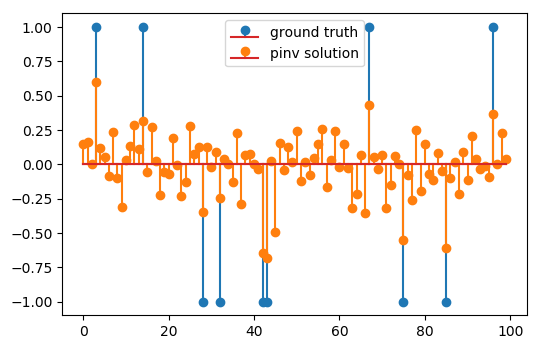

In [17]:
x_pinv = la.lstsq(Phi, y, rcond=None)[0]
_ = plt.figure(dpi=dpi)
sparse.stem(x0, "C0", "ground truth")
sparse.stem(x_pinv, "C1", "pinv solution")
plt.show()

We see that even if $x^\dagger$ is a solution of the linear system, it is far from $x_0$, and doesn't share at all the same sparse structure.
One could argue here that $x^\dagger$ has high intensities on the support of $x_0$, and so that it would be sufficient to pass it trough a high-pass filter.
But this is not true everywhere, and $x^\dagger$ might have quite high intensities elsewhere, implying that setting up the right threshold would be a hard problem.

To recover $x_0$ from $y$ we would need to solve ($P_0$), but this is a hard optimisation problem: it consists in minimising a nonsmooth function over a constraint onto which it is expensive to project on. 

Instead, we are going to look for an approximation of $x_0$, considering solutions coming from a *regularisation method*. 

### 2. The penalised problem

In this example, we are going to consider a variational regularisation method, based on *penalisation*, like the Tikhonov regularisation method.
The idea is quite simple: instead of solving ($P_0$), we are going to solve an other problem which can be seen as a perturbation of ($P_0$). 
More concretely, we are going to relax the constraint $\Phi x= y$ and replace it by a penalisation term:

\begin{equation}
\min\limits_{x \in \RR^N} f_\lambda(x):= \Vert x \Vert_1 + \frac{1}{2 \lambda}\Vert \Phi x - y \Vert^2.
\tag{$P_\lambda$}
\end{equation}

The rationale behind this is that, when $\lambda \sim 0$, the solutions of ($P_\lambda$) must verify $\Phi x_\lambda \sim y$  "first", and also having a low $\ell^1$ norm, which makes them a good approximation of $x_0$.
This problem is called the [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics)) in certain comunities, in particular in statistics and compressed sensing.

What we need now is to find a solution of ($P_\lambda$), for a given (small) parameter $\lambda$.
For this, we are going to use the [Forward-Backward algorithm](https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm).
Given an initialization $x^0 \in \RR^N$ and a stepsize $0 < \tau < \frac{2}{\Vert \Phi^* \Phi \Vert}$, the Forward-Backward algorithm writes as follows:

\begin{equation}
x^{k+1} = \text{Soft}_{\lambda \tau}(x^k - \tau \Phi^*(\Phi x^k - y))
\end{equation}

where $\text{Soft}_{\alpha} : \RR^N \rightarrow \RR^N$ is the Soft-Thresholding operator, defined for all $\alpha > 0$ by

\begin{equation}
\text{Soft}_{\alpha}(x) := \left(\text{soft}_{\alpha}(x_i)\right)_{i=1,..,N}, \quad \text{ where } \text{soft}_{\alpha}(x_i) = 
\begin{cases}
0 & \text{ if } \vert x_i \vert \leq \alpha \\
x - \text{sgn}(x_i) \lambda & \text{ if } \vert x_i \vert \geq \lambda
\end{cases}
\end{equation}




In [18]:
def fb_lasso(A, y, reg_param, iter_nb, x_ini=None, verbose=False):
    ''' Use the Forward-Backward algorithm to find a minimizer of:
             reg_param*norm(x,1) + 0.5*norm(Ax-y,2)**2
        Eventually outputs the functional values and support of the iterates 
        while running the method
    '''
    # Manage optional input/output
    if verbose:  # Optional output
        regret = np.zeros(iter_nb)
        support = np.zeros(iter_nb)
        details = {
            "function_value": regret,
            "iterate_support": support
        }
    if x_ini is not None:
        x = x_ini
    else:
        x = np.zeros((A.shape[1], 1))

    # The core of the algorithm
    stepsize = 0.8 * 2/la.norm(A, 2)**2
    for k in range(iter_nb):
        x = x - stepsize * A.T@(A@x - y)
        x = sparse.soft_thresholding(x, reg_param*stepsize)
        if verbose:
            regret[k] = 0.5*la.norm(A@x-y, 2)**2 + reg_param*la.norm(x, 1)
            support[k] = sparse.norm0(x)
    
    # Output
    if verbose:
        return x, details
    else:
        return x

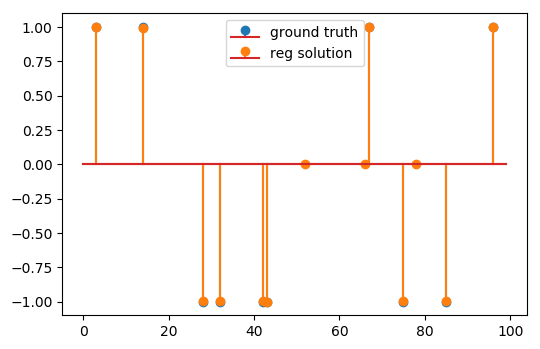

In [19]:
reg_param = 0.1  # We take lambda close to zero. Try to change it!
iter_nb = 4000
x_reg, details = fb_lasso(Phi, y, reg_param, iter_nb, verbose=True)

_ = plt.figure(dpi=dpi)
sparse.stem(x0, "C0", "ground truth")
sparse.stem(x_reg, "C1", "reg solution")
plt.show()

We hardly see the difference between $x_\lambda$ and $x_0$ when $\lambda =$0.1.
The only noticeable difference is the apparition of spikes having a negligeable amplitude. 

We can look more into details to iterates generated by the algorithm.
In particular, we see that the support of the iterates is essentially decreasing (not monotonically though), until a point where it reaches a stable support.

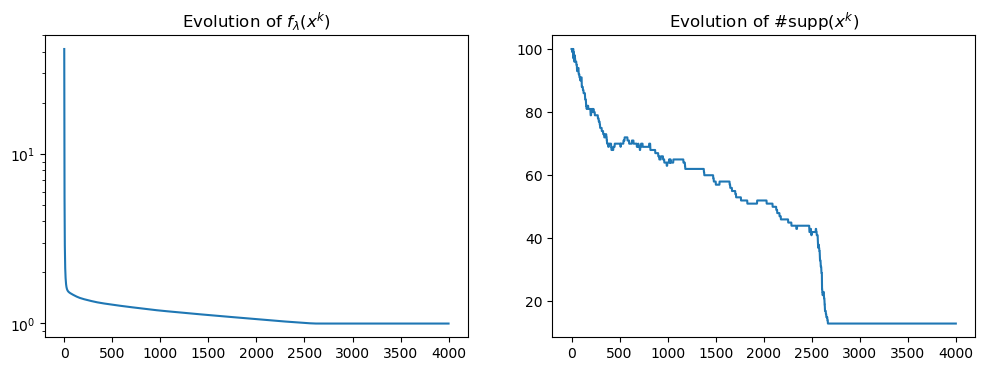

In [20]:
plt.figure(dpi=dpi, figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title(r"Evolution of $f_\lambda(x^k)$")
plt.semilogy(details.get("function_value"))

plt.subplot(1, 2, 2)
plt.title(r"Evolution of #supp$(x^k)$")
plt.plot(details.get("iterate_support"))
plt.show()

### 3. The regularisation path

The set 

$$\{x_\lambda \ | \ x_\lambda \text{ is a solution of } (P_\lambda), \lambda > 0 \}$$

is called the *regularization path*, and $\lambda$ is generally referred to as the *regularisation parameter*.
As we saw before, $x_\lambda \to x_0$ when $\lambda \to 0$.
Here we will try to visualise the set of regularised solutions.

First, here is a precalculated animation showing $x_\lambda$ for varying values of $\lambda$.
See how $x_\lambda$ starts from zero (when $\lambda$ is large), and then converges to $x_0$ by progressively getting spikes "growing".
See also how additional spikes appear and then tend to vanish along time.
![SegmentLocal](output/L1_reg/reg_path_noiseless.gif "segment")

Now, if you want to compute yourself these solutions, you just need to use the algorithm introduced above.
Here is some code to do so.

In [21]:
def compute_solution(reg_param):
    ''' Given a regularisation parameter, we compute the corresponding 
        regularized solution with the FB algorithm. The number of 
        iterations to use is customly chosen.
    '''
    reg_param = round(reg_param,1)  # For display purposes
    
    # Choice of the stopping criterion
    if reg_param > 10:
        iter_nb = 200
    else:
        if reg_param > 1:
            iter_nb = 1000
        else:
            iter_nb = 3000
    # We get the solution        
    x_reg = fb_lasso(Phi, y, reg_param, iter_nb)
    # We plot it        
    _ = plt.cla()
    _ = plt.title(r"Regularisation parameter $\lambda=$" + str(reg_param))
    sparse.stem(x0, "C0","ground truth")
    sparse.stem(x_reg, "C1", "reg solution")
    _ = plt.show()

In [22]:
_ = plt.figure(dpi=dpi, figsize=(12, 6))
interactive(compute_solution,reg_param=(1,100,1))

interactive(children=(IntSlider(value=50, description='reg_param', min=1), Output()), _dom_classes=('widget-in…

<Figure size 1200x600 with 0 Axes>